# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

## 목차
[Step1. 사진 모으기](#Step1.-사진-모으기)\
[Step2. 사진 모으기](#Step2.-사진-모으기)\
[Step3. 얼굴 영역의 임베딩 추출하기](#Step3.-얼굴-영역의-임베딩-추출하기)\
[Step4. 모은 그림들과 비교하기](#Step4.-모은-그림들과-비교하기)\
[Step5. 다양한 재미있는 시각화 시도해 보기](#Step5.-다양한-재미있는-시각화-시도해-보기)\
[Rubric](#Rubric)\
[회고](#회고)

### 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

전혀 가공되지 않은 텍스트 데이터 가공하여 `data_loader` 만들기
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전`word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### 4) 모델구성 및 validation set 구성

 3가지 이상 다양하게 구성하여 실험

In [7]:
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 41  # 워드 임베딩 벡터의 차원 수

#### 1. Recurrent Neural Network(RNN) (LSTM)

In [8]:
rmodel = keras.Sequential(name='LSTM')
rmodel.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rmodel.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
rmodel.add(keras.layers.Dense(8, activation='relu'))
rmodel.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rmodel.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1600      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 411,681
Trainable params: 411,681
Non-trainable params: 0
_________________________________________________________________


#### 2. 1-D Convolution Neural Network(1-D CNN)

In [9]:
cmodel = keras.Sequential()
cmodel.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cmodel.add(keras.layers.Conv1D(16, 7, activation='relu'))
cmodel.add(keras.layers.MaxPooling1D(5))
cmodel.add(keras.layers.Conv1D(16, 7, activation='relu'))
cmodel.add(keras.layers.GlobalMaxPooling1D())
cmodel.add(keras.layers.Dense(8, activation='relu'))
cmodel.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9

#### 3. GlobalMaxPooling1D

In [10]:
gmodel = keras.Sequential()
gmodel.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmodel.add(keras.layers.GlobalMaxPooling1D())
gmodel.add(keras.layers.Dense(8, activation='relu'))
gmodel.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 41)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 336       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [12]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

#### 1. Recurrent Neural Network(RNN) (LSTM)

In [13]:
rmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

rhistory = rmodel.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 7s 14ms/step - loss: 0.5660 - accuracy: 0.7073 - val_loss: 0.3176 - val_accuracy: 0.8686
Epoch 2/20
286/286 [==============================] - 3s 12ms/step - loss: 0.3295 - accuracy: 0.8611 - val_loss: 0.2915 - val_accuracy: 0.8775
Epoch 3/20
286/286 [==============================] - 3s 12ms/step - loss: 0.3047 - accuracy: 0.8727 - val_loss: 0.2795 - val_accuracy: 0.8836
Epoch 4/20
286/286 [==============================] - 3s 12ms/step - loss: 0.2925 - accuracy: 0.8778 - val_loss: 0.2692 - val_accuracy: 0.8901
Epoch 5/20
286/286 [==============================] - 3s 12ms/step - loss: 0.2828 - accuracy: 0.8812 - val_loss: 0.2672 - val_accuracy: 0.8908
Epoch 6/20
286/286 [==============================] - 3s 12ms/step - loss: 0.2720 - accuracy: 0.8863 - val_loss: 0.2495 - val_accuracy: 0.8997
Epoch 7/20
286/286 [==============================] - 3s 12ms/step - loss: 0.2610 - accuracy: 0.8909 - val_loss: 0.2399 - val_accuracy: 0.9031

#### 2. 1-D Convolution Neural Network(1-D CNN)

In [15]:
cmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

chistory = cmodel.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 8s 20ms/step - loss: 0.5855 - accuracy: 0.6615 - val_loss: 0.3066 - val_accuracy: 0.8750
Epoch 2/20
286/286 [==============================] - 3s 10ms/step - loss: 0.3115 - accuracy: 0.8697 - val_loss: 0.2588 - val_accuracy: 0.8974
Epoch 3/20
286/286 [==============================] - 3s 10ms/step - loss: 0.2695 - accuracy: 0.8911 - val_loss: 0.2143 - val_accuracy: 0.9207
Epoch 4/20
286/286 [==============================] - 3s 10ms/step - loss: 0.2215 - accuracy: 0.9147 - val_loss: 0.1662 - val_accuracy: 0.9468
Epoch 5/20
286/286 [==============================] - 3s 10ms/step - loss: 0.1700 - accuracy: 0.9399 - val_loss: 0.1212 - val_accuracy: 0.9640
Epoch 6/20
286/286 [==============================] - 3s 10ms/step - loss: 0.1277 - accuracy: 0.9576 - val_loss: 0.0883 - val_accuracy: 0.9745
Epoch 7/20
286/286 [==============================] - 3s 10ms/step - loss: 0.0923 - accuracy: 0.9710 - val_loss: 0.0670 - val_accuracy: 0.9808

#### 3. GlobalMaxPooling1D

In [16]:
gmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

ghistory = gmodel.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 3s 7ms/step - loss: 0.6076 - accuracy: 0.7177 - val_loss: 0.3391 - val_accuracy: 0.8549
Epoch 2/20
286/286 [==============================] - 2s 6ms/step - loss: 0.3383 - accuracy: 0.8563 - val_loss: 0.2830 - val_accuracy: 0.8827
Epoch 3/20
286/286 [==============================] - 2s 7ms/step - loss: 0.2952 - accuracy: 0.8765 - val_loss: 0.2510 - val_accuracy: 0.8987
Epoch 4/20
286/286 [==============================] - 2s 6ms/step - loss: 0.2652 - accuracy: 0.8928 - val_loss: 0.2260 - val_accuracy: 0.9128
Epoch 5/20
286/286 [==============================] - 2s 6ms/step - loss: 0.2385 - accuracy: 0.9052 - val_loss: 0.2043 - val_accuracy: 0.9230
Epoch 6/20
286/286 [==============================] - 2s 7ms/step - loss: 0.2196 - accuracy: 0.9146 - val_loss: 0.1841 - val_accuracy: 0.9327
Epoch 7/20
286/286 [==============================] - 2s 6ms/step - loss: 0.1979 - accuracy: 0.9251 - val_loss: 0.1651 - val_accuracy: 0.9430
Epoch 

### 6) Loss, Accuracy 그래프 시각화

In [19]:
import matplotlib.pyplot as plt

rhistory_dict = rhistory.history
ghistory_dict = ghistory.history
chistory_dict = chistory.history

print(rhistory_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


#### 1. Recurrent Neural Network(RNN) (LSTM)

<Figure size 432x288 with 0 Axes>

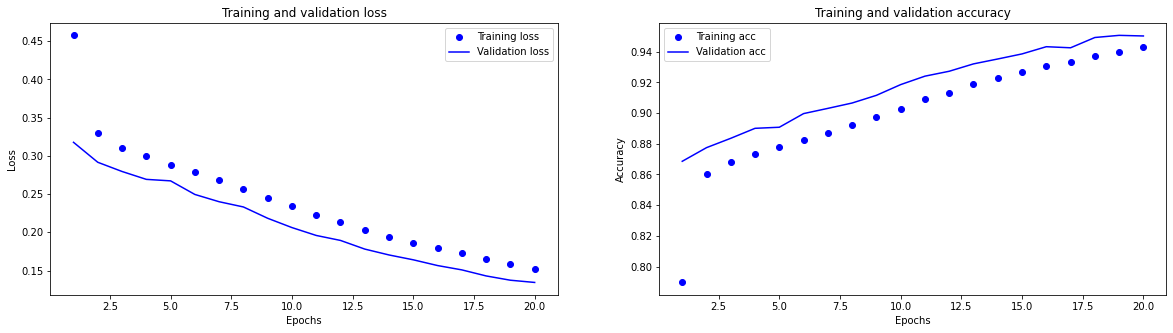

In [29]:
acc = rhistory_dict['accuracy']
val_acc = rhistory_dict['val_accuracy']
loss = rhistory_dict['loss']
val_loss = rhistory_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 2. 1-D Convolution Neural Network(1-D CNN)

<Figure size 432x288 with 0 Axes>

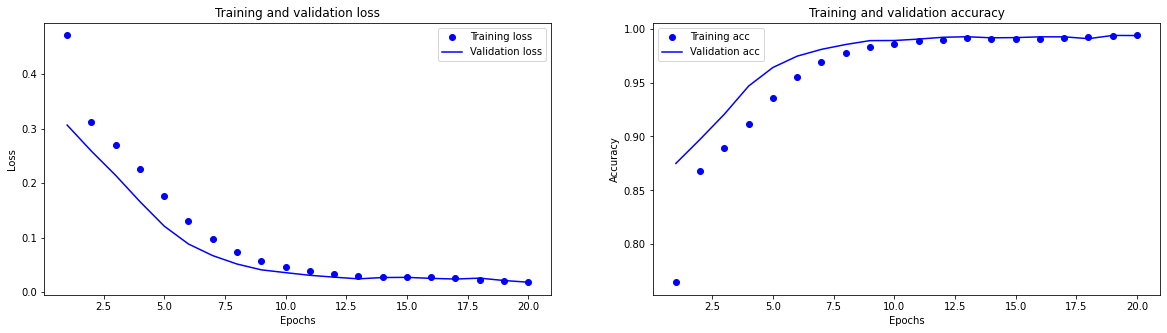

In [30]:
acc = chistory_dict['accuracy']
val_acc = chistory_dict['val_accuracy']
loss = chistory_dict['loss']
val_loss = chistory_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 3. GlobalMaxPooling1D

<Figure size 432x288 with 0 Axes>

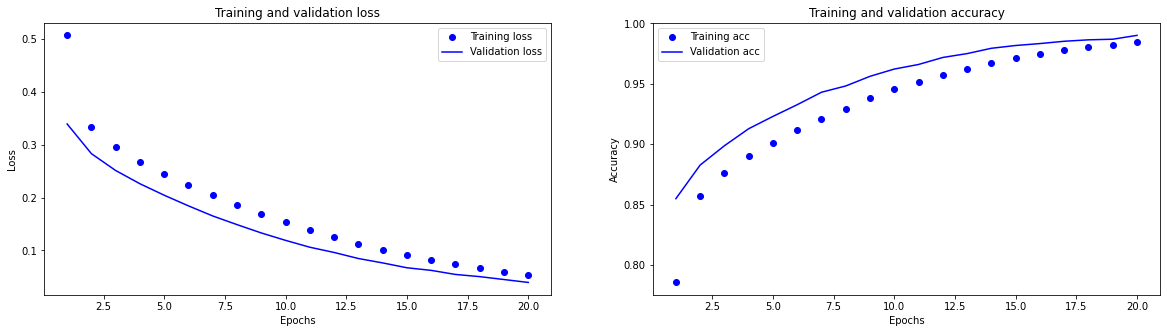

In [31]:
acc = ghistory_dict['accuracy']
val_acc = ghistory_dict['val_accuracy']
loss = ghistory_dict['loss']
val_loss = ghistory_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [32]:
embedding_layer = cmodel.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [35]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = cmodel.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


array([-0.10202723, -0.00128177, -0.07573052, -0.09324992, -0.03177639,
       -0.01303972,  0.04508541,  0.0654171 ,  0.01466324,  0.01898069,
       -0.01566392, -0.05077261, -0.01747354,  0.02747406, -0.05304415,
       -0.01206357,  0.01526798,  0.00092638, -0.01618602,  0.015239  ,
        0.10398815, -0.09596072, -0.01708332,  0.01267233, -0.03646652,
        0.02185701, -0.02453002,  0.0524874 ,  0.02865273,  0.0402237 ,
        0.05684689, -0.00112247,  0.02198933, -0.07116511,  0.03123534,
       -0.01469897, -0.08544479, -0.08762612,  0.02466797,  0.02638601,
       -0.01970724], dtype=float32)

In [38]:
word_vectors.similar_by_word("반전")

[('?????', 0.6605104207992554),
 ('유료', 0.6334942579269409),
 ('머저리', 0.6315675377845764),
 ('오프닝', 0.6219555735588074),
 ('빨간', 0.6101475358009338),
 ('변한', 0.5989477634429932),
 ('섬세', 0.5934388637542725),
 ('어째서', 0.5917163491249084),
 ('나니아', 0.5895678997039795),
 ('선입견', 0.5878247022628784)]

||  <center>**평가 문항**</center> |  <center>**상세 기준**</center> |
|:--------|:--------|:--------|
|**1**|다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.|3가지 이상의 모델이 성공적으로 시도됨|
|**2**|gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
|**3**|한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|